In [1]:
# 挂载谷歌云盘
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 学习任务：
前言
> 由于目标检测网络原理的复杂性，在正式的跑训练脚本愉快炼丹前，还有很多枯燥的概念需要学习。

> 塔们说，这是练死劲儿，不好用，我说这个好用，这叫基本功，炼丹师讲究的就是基本功。

> 因此在task2中，我们需要学习两块原理性的内容：锚框 和 目标检测的网络结构设计

任务：

了解锚框的概念及作用

学习锚框的生成代码

学习本教程所介绍的网络结构，包括特征提取模块和输出模块

学习边界框的编解码，并思考其作用

思考anchor是如何在网络中发挥作用的。

- 学习资料

  - [3.3 锚框 or 先验框](https://datawhalechina.github.io/dive-into-cv-pytorch/#/chapter03_object_detection_introduction/3_3)
  - [3.4 模型结构](https://datawhalechina.github.io/dive-into-cv-pytorch/#/chapter03_object_detection_introduction/3_4)

# 先验框

在众多经典的目标检测模型中，均有先验框的说法，有的paper(如Faster RCNN)中称之为anchor(锚点)，有的paper(如SSD)称之为prior bounding box(先验框)，实际上是一个概念。



## 设置不同尺度的先验框

通常，为了覆盖更多可能的情况，在图中的同一个位置，我们会设置几个不同尺度的先验框。这里所说的不同尺度，不单单指大小，还有长宽比，如下面的示意图所示：



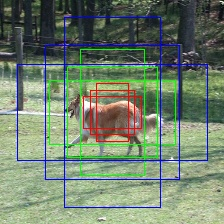

可以看到，通过设置不同的尺度的先验框，就有更高的概率出现对于目标物体有良好匹配度的先验框（体现为高IoU）。



## 先验框与特征图的对应

除了不同尺度，我们肯定要将先验框铺洒在图片中不同位置上面。


但是遍历原图每个像素，设置的先验框就太多了，完全没必要。如图3-13所示。一个224x224的图片，假设每个位置设置3个不同尺寸的先验框，那么就有224x224x3=150528个，但是如果我们不去遍历原图，而是去遍历原图下采样得到的feature map呢？以vgg16的backbone为例，下采样了5次，得到7x7的feature map，那就只需要得到7x7x3=147个先验,这样的设置大大减少了先验框的数量，同时也能覆盖大多数情况。



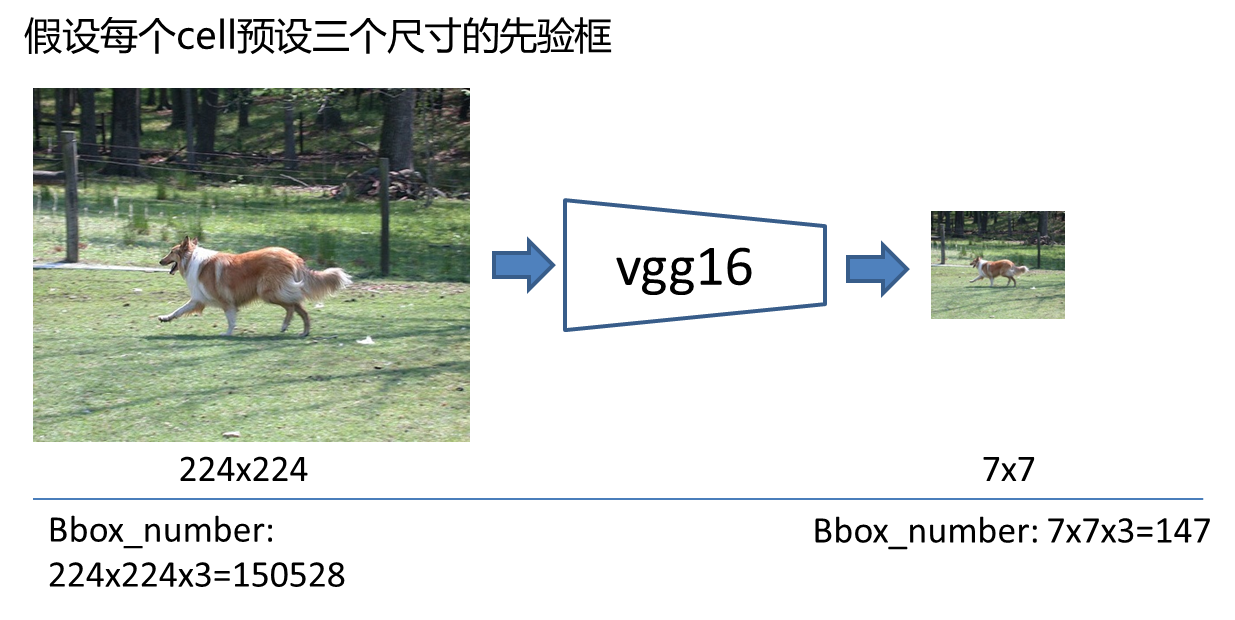

## 先验框类别信息的确定

我们铺设了很多的先验框，我们先要给出这些先验框的类别信息，才能让模型学着去预测每个先验框是否对应着一个目标物体。

这些先验框中有很多是和图片中我们要检测的目标完全没有交集或者有很小的交集，

我们的做法是，设定一个IoU阈值，例如IoU=0.5，与图片中目标的IoU<0.5的先验框，这些框我们将其划分为背景，IoU>=0.5的被归到目标先验框，通过这样划分，得到供模型学习的ground truth信息，如图所示:

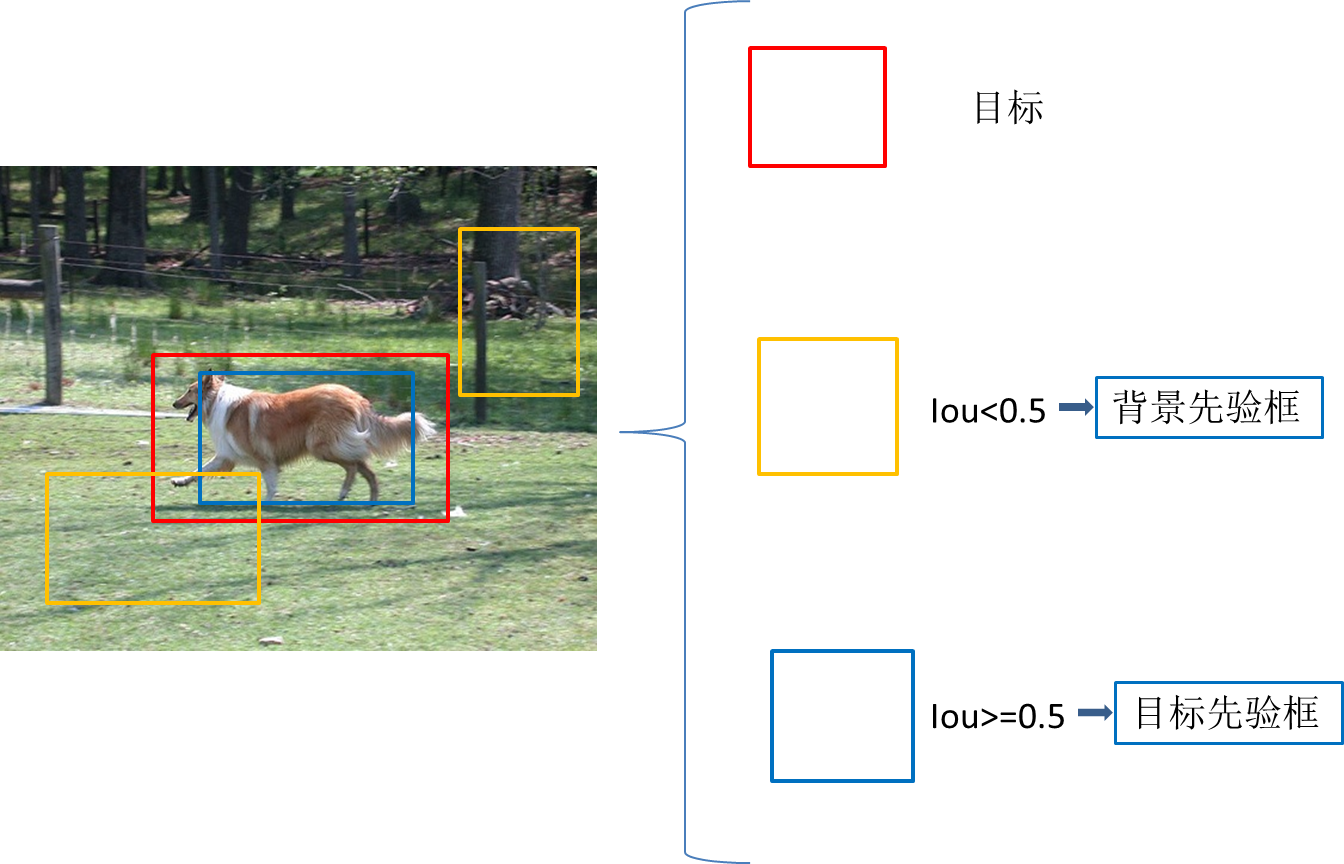

# 先验框的生成

In [6]:
from math import sqrt
import torch
device = 'cpu'

In [2]:
"""
设置细节介绍：
1. 离散程度 fmap_dims = 7： VGG16最后的特征图尺寸为 7*7
2. 在上面的举例中我们是假设了三种尺寸的先验框，然后遍历坐标。在先验框生成过程中，先验框的尺寸是提前设置好的，
   本教程为特征图上每一个cell定义了共9种不同大小和形状的候选框（3种尺度*3种长宽比=9）

生成过程：
0. cx， cy表示中心点坐标
1. 遍历特征图上每一个cell，i+0.5是为了从坐标点移动至cell中心，/fmap_dims目的是将坐标在特征图上归一化
2. 这个时候我们已经可以在每个cell上各生成一个框了，但是这个不是我们需要的，我们称之为base_prior_bbox基准框。
3. 根据我们在每个cell上得到的长宽比1:1的基准框，结合我们设置的3种尺度obj_scales和3种长宽比aspect_ratios就得到了每个cell的9个先验框。
4. 最终结果保存在prior_boxes中并返回。

需要注意的是，这个时候我们的到的先验框是针对特征图的尺寸并归一化的，因此要映射到原图计算IOU或者展示，需要：
img_prior_boxes = prior_boxes * 图像尺寸
"""

def create_prior_boxes():
        """
        Create the 441 prior (default) boxes for the network, as described in the tutorial.
        VGG16最后的特征图尺寸为 7*7
        我们为特征图上每一个cell定义了共9种不同大小和形状的候选框（3种尺度*3种长宽比=9）
        因此总的候选框个数 = 7 * 7 * 9 = 441
        :return: prior boxes in center-size coordinates, a tensor of dimensions (441, 4)
        """
        fmap_dims = 7 
        obj_scales = [0.2, 0.4, 0.6]
        aspect_ratios = [1., 2., 0.5]

        prior_boxes = []
        for i in range(fmap_dims):
            for j in range(fmap_dims):
                cx = (j + 0.5) / fmap_dims
                cy = (i + 0.5) / fmap_dims

                for obj_scale in obj_scales:
                    for ratio in aspect_ratios:

                      # 这里先验框的坐标形式就是(cx,cy,w,h)
                      prior_boxes.append([cx, cy, obj_scale * sqrt(ratio), obj_scale / sqrt(ratio)])

        prior_boxes = torch.FloatTensor(prior_boxes).to(device)  # (441, 4)
        # 截断,使点不会越界,因为图片是归一化过的,所以截断至0~1的区间即可
        prior_boxes.clamp_(0, 1)  # (441, 4)

        return prior_boxes


In [7]:
create_prior_boxes()

tensor([[0.0714, 0.0714, 0.2000, 0.2000],
        [0.0714, 0.0714, 0.2828, 0.1414],
        [0.0714, 0.0714, 0.1414, 0.2828],
        ...,
        [0.9286, 0.9286, 0.6000, 0.6000],
        [0.9286, 0.9286, 0.8485, 0.4243],
        [0.9286, 0.9286, 0.4243, 0.8485]])

#  模型结构



## backbone

为了使结构简单易懂，我们使用VGG16作为backbone，即完全采用vgg16的结构作为特征提取模块，只是去掉fc6和fc7两个全连接层。如图所示：


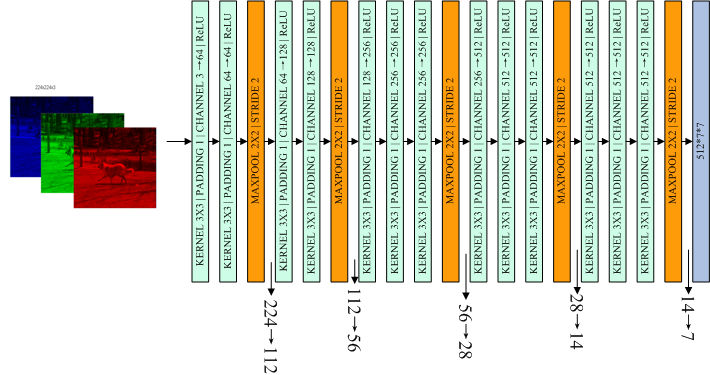

In [ ]:
class VGGBase(nn.Module):                                                                                                                                         
    """
    VGG base convolutions to produce feature maps.
    完全采用vgg16的结构作为特征提取模块，丢掉fc6和fc7两个全连接层。
    因为vgg16的ImageNet预训练模型是使用224×224尺寸训练的，因此我们的网络输入也固定为224×224
    """

    def __init__(self):
        super(VGGBase, self).__init__()

        # Standard convolutional layers in VGG16
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # stride = 1, by default # in_channel, out_channel ,kennel_size,stride
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)    # 224->112

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)    # 112->56

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)    # 56->28

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)    # 28->14

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)    # 14->7

        # Load pretrained weights on ImageNet
        self.load_pretrained_layers()


    def forward(self, image):
        """
        Forward propagation.

        :param image: images, a tensor of dimensions (N, 3, 224, 224)
        :return: feature maps pool5
        """
        out = F.relu(self.conv1_1(image))  # (N, 64, 224, 224)
        out = F.relu(self.conv1_2(out))  # (N, 64, 224, 224)
        out = self.pool1(out)  # (N, 64, 112, 112)

        out = F.relu(self.conv2_1(out))  # (N, 128, 112, 112)
        out = F.relu(self.conv2_2(out))  # (N, 128, 112, 112)
        out = self.pool2(out)  # (N, 128, 56, 56)

        out = F.relu(self.conv3_1(out))  # (N, 256, 56, 56)
        out = F.relu(self.conv3_2(out))  # (N, 256, 56, 56)
        out = F.relu(self.conv3_3(out))  # (N, 256, 56, 56)
        out = self.pool3(out)  # (N, 256, 28, 28)

        out = F.relu(self.conv4_1(out))  # (N, 512, 28, 28)
        out = F.relu(self.conv4_2(out))  # (N, 512, 28, 28)
        out = F.relu(self.conv4_3(out))  # (N, 512, 28, 28)
        out = self.pool4(out)  # (N, 512, 14, 14)

        out = F.relu(self.conv5_1(out))  # (N, 512, 14, 14)
        out = F.relu(self.conv5_2(out))  # (N, 512, 14, 14)
        out = F.relu(self.conv5_3(out))  # (N, 512, 14, 14)
        out = self.pool5(out)  # (N, 512, 7, 7)

        # return 7*7 feature map                                                                                                                                  
        return out

    # 加载torchvision中vgg16模型预训练的参数
    def load_pretrained_layers(self):
        """
        we use a VGG-16 pretrained on the ImageNet task as the base network.
        There's one available in PyTorch, see https://pytorch.org/docs/stable/torchvision/models.html#torchvision.models.vgg16
        We copy these parameters into our network. It's straightforward for conv1 to conv5.
        """
        # Current state of base
        state_dict = self.state_dict()
        param_names = list(state_dict.keys())

        # Pretrained VGG base
        pretrained_state_dict = torchvision.models.vgg16(pretrained=True).state_dict()
        pretrained_param_names = list(pretrained_state_dict.keys())

        # Transfer conv. parameters from pretrained model to current model
        for i, param in enumerate(param_names):  
            state_dict[param] = pretrained_state_dict[pretrained_param_names[i]]

        self.load_state_dict(state_dict)
        print("\nLoaded base model.\n")


关于先验框的概念，上节已经做了介绍，在本实验中，anchor的配置如下：

将原图均匀分成7x7个cell
设置3种不同的尺度：0.2, 0.4, 0.6
设置3种不同的长宽比：1:1, 1:2, 2:1
因此，我们对这 7x7 的 feature map 设置了对应的7x7x9个anchor框，其中每一个cell有9个anchor框，如图所示：



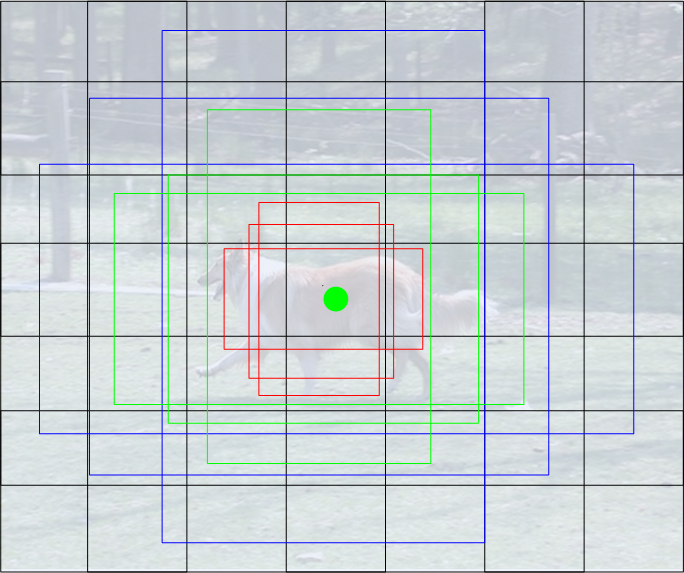

对于每个anchor，我们需要预测两类信息，一个是这个anchor的类别信息，一个是物体的边界框信息。如下图：

在我们的实验中，类别信息由21类别的得分组成（VOC数据集的20个类别 + 一个背景类），模型最终会选择预测得分最高的类作为边界框对象的类别。

而边界框信息是指，我们大致知道了当前anchor中包含一个物体的情况下，如何对anchor进行微调，使得最终能够准确预测出物体的bbox。

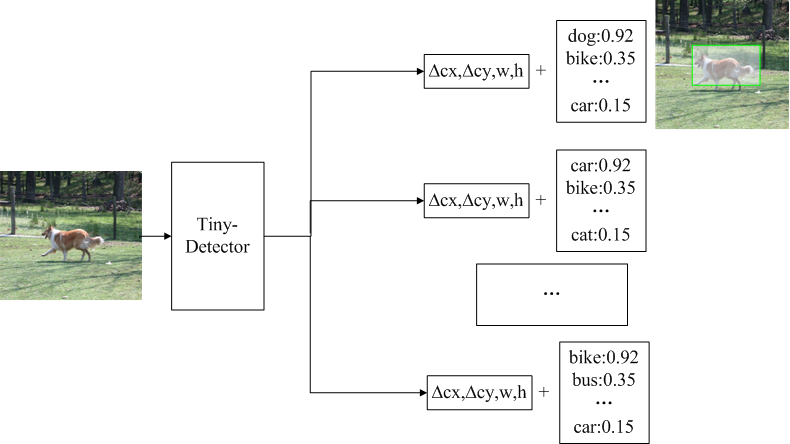

这两种预测我们分别成为分类头和回归头，那么分类头预测和回归头预测是怎么得到的？

其实我们只需在7x7的feature map后，接上两个3x3的卷积层，即可分别完成分类和回归的预测。

# 分类头和回归头


Tiny_Detector并不是直接预测目标框，而是回归对于anchor要进行多大程度的调整，才能更准确的预测出边界框的位置。那么我们的目标就是需要找一种方法来量化计算这个偏差。



## 边界框的编解码

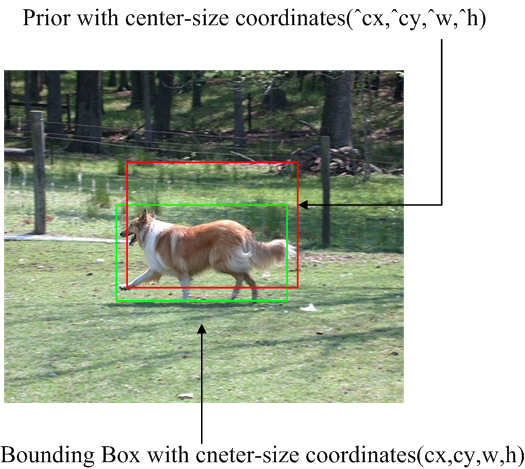

公式如下

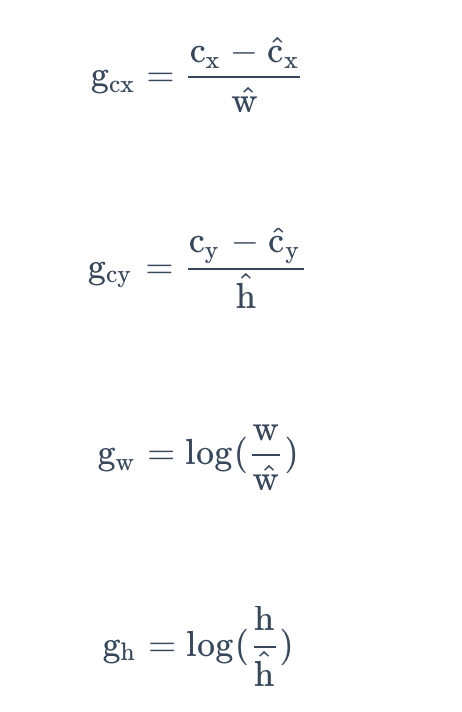

### 大白话版

边界框中心点x坐标 = (真实边界框中心的x坐标 - 预测边界框中心的x坐标) / 预测边框的宽度

g_cx = (cx_true - cx_pred) / w_pred

边界框中心点y坐标 = (真实边界框中心的y坐标 - 预测边界框中心的y坐标) / 预测边界框的高度

g_cy = (cy_true - cy_pred) / h_pred

边界框的宽度 = log(真实边界框的宽度 / 预测边界框的宽度)

g_w = log(w_true / w_pred)

边界框的高度 = log(真实边界框的高度 / 预测边界框的高度)

g_h = log(h_true / h_pred)

### **code**

In [ ]:
def cxcy_to_gcxgcy(cxcy, priors_cxcy):
    """ 
    Encode bounding boxes (that are in center-size form) w.r.t. the corresponding prior boxes (that are in center-size form).

    For the center coordinates, find the offset with respect to the prior box, and scale by the size of the prior box.
    For the size coordinates, scale by the size of the prior box, and convert to the log-space.

    In the model, we are predicting bounding box coordinates in this encoded form.

    :param cxcy: bounding boxes in center-size coordinates, a tensor of size (n_priors, 4)
    :param priors_cxcy: prior boxes with respect to which the encoding must be performed, a tensor of size (n_priors, 4)
    :return: encoded bounding boxes, a tensor of size (n_priors, 4)
    """

    # The 10 and 5 below are referred to as 'variances' in the original SSD Caffe repo, completely empirical
    # They are for some sort of numerical conditioning, for 'scaling the localization gradient'
    # See https://github.com/weiliu89/caffe/issues/155
    return torch.cat([(cxcy[:, :2] - priors_cxcy[:, :2]) / (priors_cxcy[:, 2:] / 10),  # g_c_x, g_c_y
                      torch.log(cxcy[:, 2:] / priors_cxcy[:, 2:]) * 5], 1)  # g_w, g_h


def gcxgcy_to_cxcy(gcxgcy, priors_cxcy):
    """ 
    Decode bounding box coordinates predicted by the model, since they are encoded in the form mentioned above.

    They are decoded into center-size coordinates.

    This is the inverse of the function above.

    :param gcxgcy: encoded bounding boxes, i.e. output of the model, a tensor of size (n_priors, 4)
    :param priors_cxcy: prior boxes with respect to which the encoding is defined, a tensor of size (n_priors, 4)
    :return: decoded bounding boxes in center-size form, a tensor of size (n_priors, 4)
    """

    return torch.cat([gcxgcy[:, :2] * priors_cxcy[:, 2:] / 10 + priors_cxcy[:, :2],  # c_x, c_y
                      torch.exp(gcxgcy[:, 2:] / 5) * priors_cxcy[:, 2:]], 1)  # w, h


# 分类头与回归头预测

按照前面的介绍，对于输出7x7的feature map上的每个先验框我们想预测：

1）边界框的一组21类分数，其中包括VOC的20类和一个背景类。

2）边界框编码后的偏移量(g_cx,g_cy,g_w,g_hg)。

为了得到我们想预测的类别和偏移量，我们需要在feature map后分别接上两个卷积层：

1）一个分类预测的卷积层采用3x3卷积核padding和stride都为1，每个anchor需要分配21个卷积核，每个位置有9个anchor，因此需要21x9个卷积核。

2）一个定位预测卷积层，每个位置使用3x3卷积核padding和stride都为1，每个anchor需要分配4个卷积核，因此需要4x9个卷积核。

我们直观的看看这些卷积上的输出，见下图：



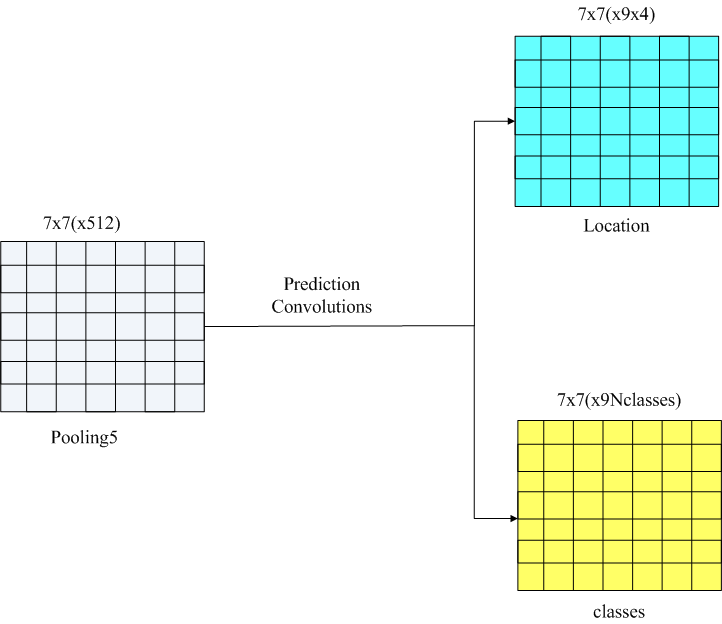

这个回归头和分类头的输出分别用蓝色和黄色表示。其feature map的大小7x7保持不变。我们真正关心的是第三维度通道数，把其具体的展开可以看到如下图所示：



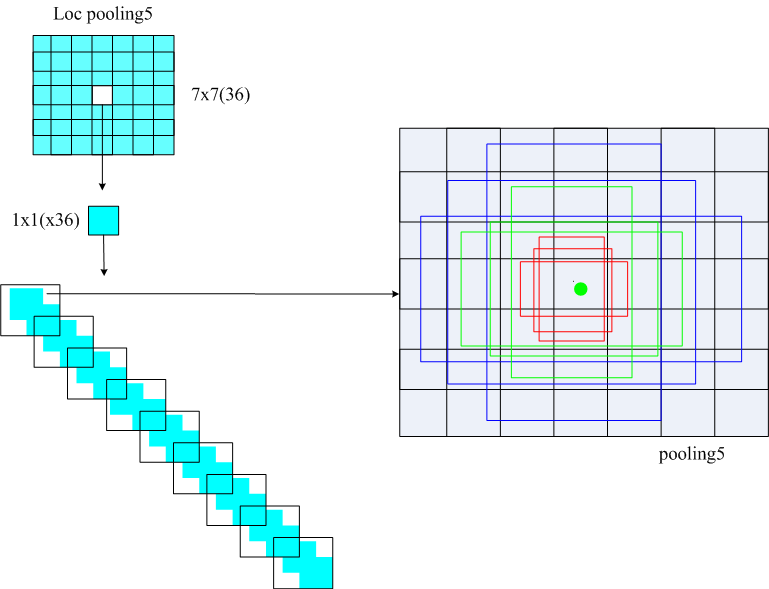

也就是说，最终回归头的输出有36个通道，其中每4个值就对应了一个anchor的编码后偏移量的预测，这样的4个值的预测共有9组，因此通道数是36。



分类头可以用同样的方式理解，如下图所示:



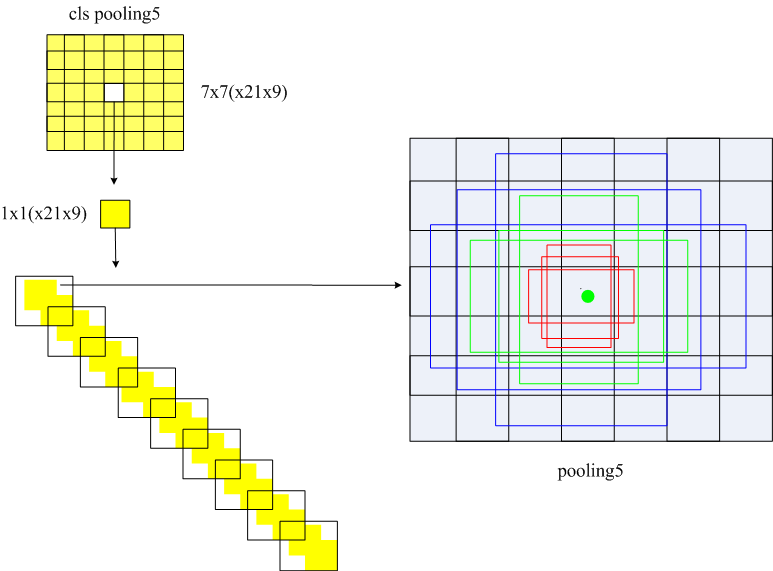

## code

In [ ]:
class PredictionConvolutions(nn.Module):
    """ 
    Convolutions to predict class scores and bounding boxes using feature maps.

    The bounding boxes (locations) are predicted as encoded offsets w.r.t each of the 441 prior (default) boxes.
    See 'cxcy_to_gcxgcy' in utils.py for the encoding definition.
    这里预测坐标的编码方式完全遵循的SSD的定义

    The class scores represent the scores of each object class in each of the 441 bounding boxes located.
    A high score for 'background' = no object.
    """

    def __init__(self, n_classes):
        """ 
        :param n_classes: number of different types of objects
        """
        super(PredictionConvolutions, self).__init__()

        self.n_classes = n_classes

        # Number of prior-boxes we are considering per position in the feature map
        # 9 prior-boxes implies we use 9 different aspect ratios, etc.
        n_boxes = 9 

        # Localization prediction convolutions (predict offsets w.r.t prior-boxes)
        self.loc_conv = nn.Conv2d(512, n_boxes * 4, kernel_size=3, padding=1)

        # Class prediction convolutions (predict classes in localization boxes)
        self.cl_conv = nn.Conv2d(512, n_boxes * n_classes, kernel_size=3, padding=1)

        # Initialize convolutions' parameters
        self.init_conv2d()


    def init_conv2d(self):
        """
        Initialize convolution parameters.
        """
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)


    def forward(self, pool5_feats):
        """
        Forward propagation.

        :param pool5_feats: conv4_3 feature map, a tensor of dimensions (N, 512, 7, 7)
        :return: 441 locations and class scores (i.e. w.r.t each prior box) for each image
        """
        batch_size = pool5_feats.size(0)

        # Predict localization boxes' bounds (as offsets w.r.t prior-boxes)
        l_conv = self.loc_conv(pool5_feats)  # (N, n_boxes * 4, 7, 7)
        l_conv = l_conv.permute(0, 2, 3, 1).contiguous()  
        # (N, 7, 7, n_boxes * 4), to match prior-box order (after .view())
        # (.contiguous() ensures it is stored in a contiguous chunk of memory, needed for .view() below)
        locs = l_conv.view(batch_size, -1, 4)  # (N, 441, 4), there are a total 441 boxes on this feature map

        # Predict classes in localization boxes
        c_conv = self.cl_conv(pool5_feats)  # (N, n_boxes * n_classes, 7, 7)
        c_conv = c_conv.permute(0, 2, 3, 1).contiguous()  # (N, 7, 7, n_boxes * n_classes), to match prior-box order (after .view())
        classes_scores = c_conv.view(batch_size, -1, self.n_classes)  # (N, 441, n_classes), there are a total 441 boxes on this feature map

        return locs, classes_scores


按照上面的介绍，我们的模型输出的shape应该为：

- 分类头 batch_size x 7 x 7 x 189
- 回归头 batch_size x 7 x 7 x 36

但是为了方便后面的处理，我们肯定更希望每个anchor的预测独自成一维，也就是：

- 分类头 batch_size x 441 x 21
- 回归头 batch_size x 441 x 4

441是因为我们的模型定义了总共`441=7x7x9`个先验框，这个转换对应了这两行代码:

```
locs = l_conv.view(batch_size, -1, 4)
classes_scores = c_conv.view(batch_size, -1, self.n_classes)
```

这个过程的可视化如图所示。

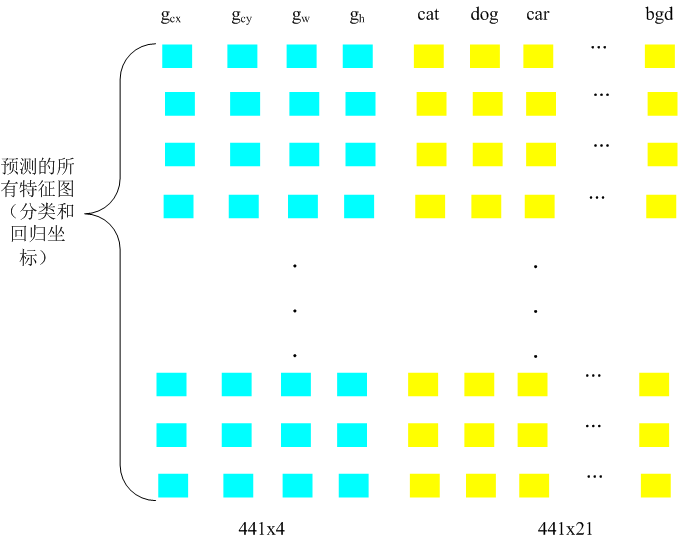

# 小结
- 学习了目标检测的先验框
- 学习了先验框的生成逻辑
- 学习了vgg16的网络结构
- 学习了分类头和回归头的生成逻辑
- 学习了分类头和回归头的使用逻辑